In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


This is our second of three tutorials on “NLP From Scratch”. In the first tutorial </intermediate/char_rnn_classification_tutorial> we used a RNN to classify names into their language of origin. This time we’ll turn around and generate names from languages.

We are still hand-crafting a small RNN with a few linear layers. The big difference is instead of predicting a category after reading in all the letters of a name, we input a category and output one letter at a time. Recurrently predicting characters to form language (this could also be done with words or other higher order constructs) is often referred to as a “language model”.

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os 
import unicodedata 
import string

all_letters = string.ascii_letters + ".,:'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def find_files(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
  return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn" and c in all_letters)

# Read a file and split into lines
def read_lines(filename):
  with open(filename, encoding="utf-8") as some_file:
    return [unicode_to_ascii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []

for filename in find_files("/content/drive/MyDrive/Datasets/RNN/data/names/*.txt"):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = read_lines(filename)
  category_lines[category] = lines


n_categories = len(all_categories)

if n_categories == 0:
  raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
  
print(f"# categories: {n_categories} {all_categories}")
print(unicode_to_ascii("O'Néàl"))

# categories: 18 ['Japanese', 'Irish', 'Russian', 'English', 'German', 'Polish', 'Scottish', 'Portuguese', 'Spanish', 'Arabic', 'Chinese', 'Italian', 'Czech', 'French', 'Korean', 'Greek', 'Dutch', 'Vietnamese']
O'Neal


This network extends the last tutorial’s RNN with an extra argument for the category tensor, which is concatenated along with the others. The category tensor is a one-hot vector just like the letter input.

We will interpret the output as the probability of the next letter. When sampling, the most likely output letter is used as the next input letter.

I added a second linear layer o2o (after combining hidden and output) to give it more muscle to work with. There’s also a dropout layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually used to fuzz inputs to prevent overfitting. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety.

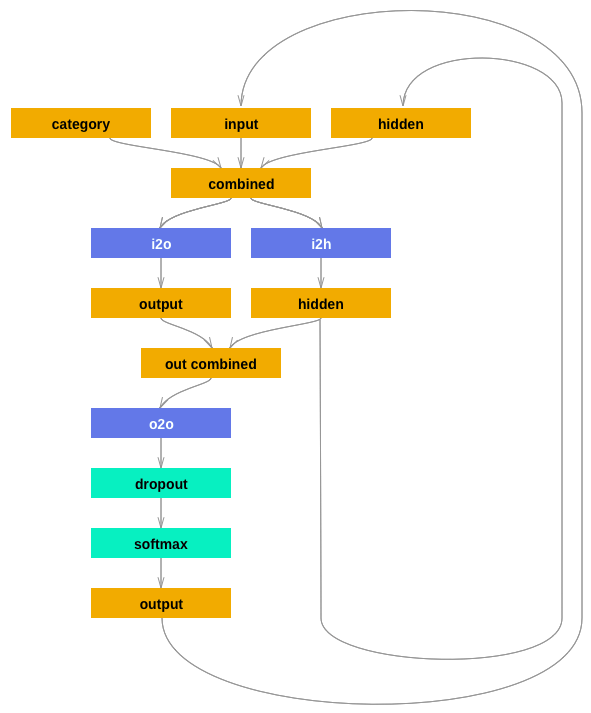

In [17]:
import torch
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, input, hidden):
    input_combined = torch.cat((category, input, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

First of all, helper functions to get random pairs of (category, line):

In [10]:
import random

# Random item from a list
def random_choice(l):
  return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def random_training_pair():
  category = random_choice(all_categories)
  line = random_choice(category_lines[category])
  return category, line

For each timestep (that is, for each letter in a training word) the inputs of the network will be (category, current letter, hidden state) and the outputs will be (next letter, next hidden state). So for each training set, we’ll need the category, a set of input letters, and a set of output/target letters.

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line - e.g. for "ABCD<EOS>" we would create (“A”, “B”), (“B”, “C”), (“C”, “D”), (“D”, “EOS”).

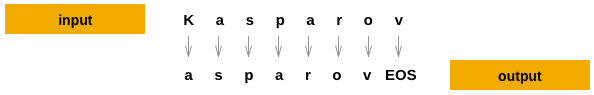

The category tensor is a one-hot tensor of size <1 x n_categories>. When training we feed it to the network at every timestep - this is a design choice, it could have been included as part of initial hidden state or some other strategy.

In [12]:
# One-hot vector for category
def categoryTensor(category):
  li = all_categories.index(category)
  tensor = torch.zeros(1, n_categories)
  tensor[0][li] = 1
  return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def input_tensor(line):
  tensor = torch.zeros(len(line), 1, n_letters)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][all_letters.find(letter)] = 1
  return tensor

# LongTensor of second letter to end (EOS) for target
def target_tensor(line):
  letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
  letter_indexes.append(n_letters - 1) #EOS
  return torch.LongTensor(letter_indexes)

For convenience during training we’ll make a randomTrainingExample function that fetches a random (category, line) pair and turns them into the required (category, input, target) tensors.

In [13]:
# Make category, input, and target tensors from a random category, line pair
def random_training_example():
  category, line = random_training_pair()
  category_tensor = categoryTensor(category)
  input_line_tensor = input_tensor(line)
  target_line_tensor = target_tensor(line)
  return category_tensor, input_line_tensor, target_line_tensor

In contrast to classification, where only the last output is used, we are making a prediction at every step, so we are calculating loss at every step.

The magic of autograd allows you to simply sum these losses at each step and call backward at the end.

In [14]:
criterion = nn.NLLLoss()

lr = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
  target_line_tensor.unsqueeze_(-1)
  hidden = rnn.init_hidden()

  rnn.zero_grad()

  loss = 0

  for i in range(input_line_tensor.size(0)):
    output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
    l = criterion(output, target_line_tensor[i])
    loss += l

  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha =-lr)

  return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a timeSince(timestamp) function which returns a human readable string:

In [15]:
import time
import math

def time_since(since):
  now = time.time()
  s = now - since
  m = math.floor(s / 60)
  s -= m * 60
  return f"{m}m {s}s"

Training is business as usual - call train a bunch of times and wait a few minutes, printing the current time and loss every print_every examples, and keeping store of an average loss per plot_every examples in all_losses for plotting later.

In [18]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
  output, loss = train(*random_training_example())
  total_loss += loss

  if iter % print_every == 0:
    print(f"{time_since(start)} ({iter} {iter // n_iters * 100}%) {loss:.4f}")

  if iter % plot_every == 0:
    all_losses.append(total_loss / plot_every)
    total_loss = 0

0m 17.114931344985962s (5000 5.0%%) 2.8630
0m 34.027706146240234s (10000 10.0%%) 2.8092
0m 51.0714647769928s (15000 15.0%%) 2.9084
1m 7.86129903793335s (20000 20.0%%) 1.8696
1m 24.97459840774536s (25000 25.0%%) 2.1157
1m 42.17775106430054s (30000 30.0%%) 2.1086
2m 0.15405750274658203s (35000 35.0%%) 2.8994
2m 17.535292863845825s (40000 40.0%%) 2.6574
2m 34.429930210113525s (45000 45.0%%) 1.6759
2m 51.288315773010254s (50000 50.0%%) 2.3131
3m 8.218052387237549s (55000 55.00000000000001%%) 2.2078
3m 25.702916145324707s (60000 60.0%%) 2.0680
3m 43.06161332130432s (65000 65.0%%) 2.5405
4m 0.24199891090393066s (70000 70.0%%) 2.3964
4m 17.557618856430054s (75000 75.0%%) 2.3582
4m 34.76201152801514s (80000 80.0%%) 1.6107
4m 51.97971796989441s (85000 85.0%%) 2.1531
5m 9.552979230880737s (90000 90.0%%) 1.9425
5m 27.327091693878174s (95000 95.0%%) 2.4381
5m 44.845863580703735s (100000 100.0%%) 2.2957


Plotting the historical loss from all_losses shows the network learning:

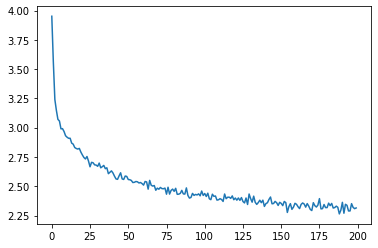

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.

* Create tensors for input category, starting letter, and empty hidden state

* Create a string output_name with the starting letter

* Up to a maximum output length,

  * Feed the current letter to the network

  * Get the next letter from highest output, and next hidden state

  * If the letter is EOS, stop here

  * If a regular letter, add to output_name and continue

* Return the final name


In [20]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter="A"):
  with torch.no_grad():  # no need to track history in sampling
    category_tensor = categoryTensor(category)
    input = input_tensor(start_letter)
    hidden = rnn.init_hidden()

    output_name = start_letter

    for i in range(max_length):
      output, hidden = rnn(category_tensor, input[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == n_letters - 1:
        break
      else:
        letter = all_letters[topi]
        output_name += letter
      input = input_tensor(letter)

    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters="ABC"):
  for start_letter in start_letters:
    print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovers
Uakin
Shinovek
Gerter
Erer
Ronger
Solla
Panda
Aller
Cue
Han
Iun
